# A Genetic - Physiological Model of Flowering

Importing the necessary modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import math

### Generating the toy temperature signal dataset array

The temperature generation model, uses a sine wave function to generate a toy temperature dataset, with some gaussian noise added to it.

$\theta _{av} + \theta _{r} \sin( (M + \frac{D}{30}) \frac{\pi}{12}) + \mathcal{N}(\mu, \sigma)$

where:

$\theta _{r} = 7.5$   ,   $\mu = 0$

$\sigma = 2$        ,     $\theta _{av} = 12$


In [2]:
def temperature_generator(num_months, average_temp = 12, temp_range = 7.5, sd_noise=1):
    """
    Function to generate Toy Temperature dataset.
    Inputs:
        num_months - the number of months for which the data is neeeded. (each month has uniform 30 days)
        average_temp - The average of the data would be around this temperature value.
        temp_range - Temperature data will be almost within (average_temp - temp_range, average_temp + temp_range)
        sd_noise - standard deviation of the gaussian noise added.
    Output:
        Days - An array of numbers 0 to num_months*30, makes plotting easier
        Temps - An array of actual time series temperature data
    """
    Temps = []
    Days = np.arange(0, num_months*30, 1)
    for M in range(num_months):
        for D in range(30):
            T = average_temp + temp_range*math.sin( (M + D/30) * (math.pi/12)) + random.gauss(0, sd_noise)
            Temps.append(T)
            
    assert(len(Days) == len(Temps))
    return (Days, Temps)

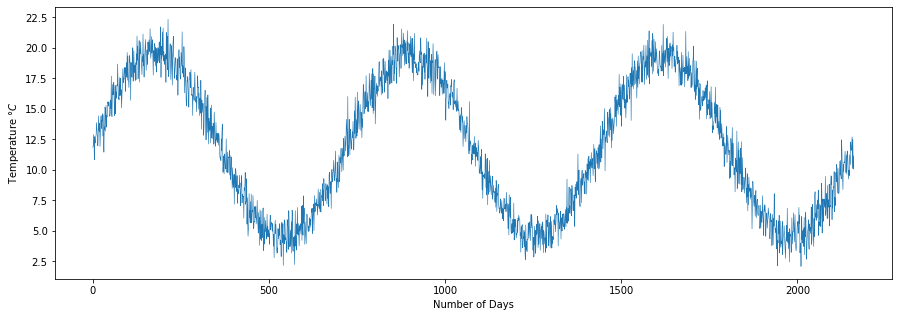

In [3]:
random.seed(42)
days, Temps = temperature_generator(72)
#days = days[200:800]
#Temps = Temps[200:800]
plt.figure(figsize=(15,5))
plt.ylabel("Temperature $\degree C$ ")
plt.xlabel("Number of Days")
plt.plot(days, Temps, linewidth = 0.6)
plt.show()
#plt.savefig("Temp_4.jpg")

### Initializing the model parameters

In [4]:
betaV = 0.5 #production rate of VIN3 transcript
alphaV = 0.1 #degradation rate of VIN3 transcript
KVIN3 = 4.5 #Threshold VIN3 transcript levels
r =  10 #Maximum transcript level of FLC
betaFT = 5.0 #Degradation rate of FT protein
alphaFT = 1.0 #Production rate of FT protein
KFLC = 0.1 #Threshold of FLC transcript levels

In [5]:
h = 0.9
a = 10
b = 1
Dx = 0.005
Dy = 1
Ds = 0.015
Cf = 2
Cs = 4
KFT = 7



### Initializing arrays for storing the values and the initial conditions for the model

In [6]:
n = len(days)
VIN3 = np.zeros(n)
RFLC = np.zeros(n)
FLC = np.zeros(n)
FT = np.zeros(n)
X = np.zeros(n)
S = np.zeros(n)
Y = np.zeros(n)


# initial Conditions
VIN3[0] = 0
RFLC[0] = 0
FLC[0] = 10
FT[0] = 0
X[0] = 1
p = 0.0
q = 0.2
KT = 10

In [7]:
p = 0.00089
q = 0.11

### Implementing the step functions of the model

In [8]:
def vernalization_threshold_step_fn(t, KT):
    if t < KT:
        return 1
    else:
        return 0

def VIN3_transcript_threshold_fn(VIN3, KVIN3):
    if VIN3 > KVIN3:
        return 1
    else:
        return 0

def FLC_threshold_fn(FLC, KFLC):
    if FLC < KFLC:
        return 1
    else:
        return 0
    
def xFT_KFT_fn(x, FT, KFT):
    if x*FT >= KFT:
        return 1
    else:
        return 0

### Solving the differential equations

Using the Euler's Method and storing the results in an array

In [9]:
for i in range(1, n):
    T = Temps[i]
    VIN3[i] = VIN3[i-1] + betaV*vernalization_threshold_step_fn(T, KT) - alphaV*VIN3[i-1]
    RFLC[i] = RFLC[i-1] + q*VIN3_transcript_threshold_fn(VIN3[i], KVIN3)*(1-RFLC[i-1]) - p*RFLC[i-1]
    FLC[i] = r*(1-RFLC[i])
    FT[i] = FT[i-1] + betaFT*FLC_threshold_fn(FLC[i], KFLC) - alphaFT*FT[i-1]
    
    X[i] = X[i-1] + h*(1 - xFT_KFT_fn(X[i-1], FT[i], KFT))* ( (a*X[i-1])/(1+b*X[i-1]) ) - Dx*X[i-1]
    S[i] = S[i-1] + (1 - h*(1 - xFT_KFT_fn(X[i], FT[i], KFT))) * ( (a*X[i])/(1+b*X[i-1]) ) - Cf * (xFT_KFT_fn(X[i], FT[i], KFT)) - Cs * Y[i-1] - Ds*S[i-1]
    Y[i] = Y[i-1] + Cf*xFT_KFT_fn(X[i], FT[i], KFT) - Dy*Y[i-1]

### Plotting time!

Plotting the levels of VIN3 and FLC transcripts and FT protein concentration

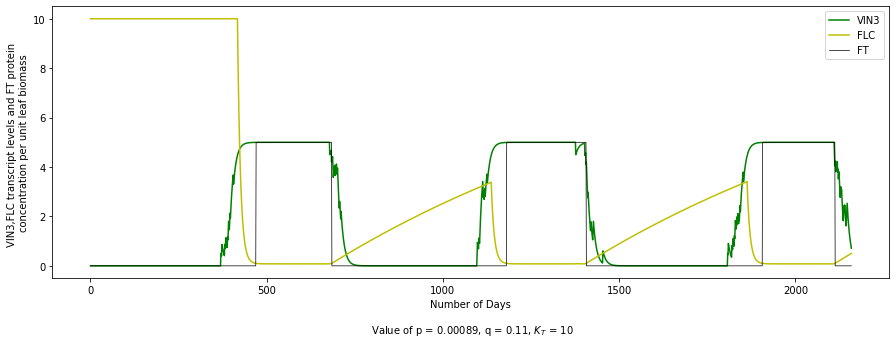

In [10]:
plt.figure(figsize=(15,5))
plt.plot(days, VIN3, "g-", label = "VIN3")
#plt.plot(days, RFLC, "b--", label = "RFLC")
#plt.plot(days, temps, "b--", label = "Temp")
plt.plot(days, FLC, "y-", label = "FLC")
plt.plot(days, FT, "k-", label = "FT", linewidth = 0.7)
plt.legend(loc = "best")
plt.xlabel("Number of Days\n\n Value of p = {}, q = {}, $K_T$ = {}".format(p, q, KT))
plt.ylabel("VIN3,FLC transcript levels and FT protein \nconcentration per unit leaf biomass")
plt.show()
#plt.savefig("fig_4.jpg")

Plotting the flowering times

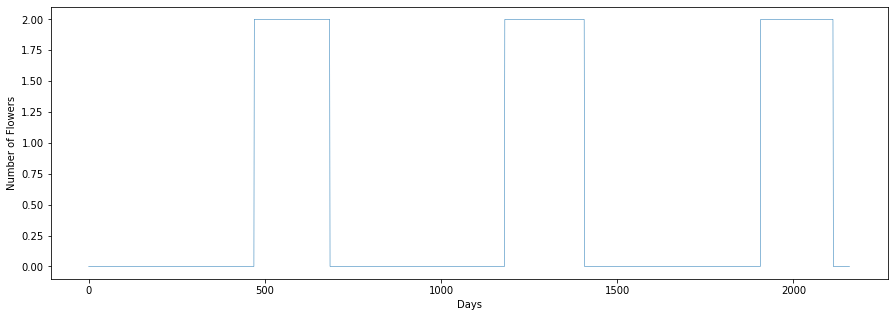

In [11]:
plt.figure(figsize=(15,5))
plt.plot(days, Y, linewidth=0.5)
plt.xlabel("Days")
plt.ylabel("Number of Flowers")
plt.show()
#plt.savefig("Flowering_4.jpg")

### Citations:

The model implemented in this project is by Prof. Akiko Satake, 2010.
 
 Satake A., Diversity of plant life cycles is generated by dynamic epigenetic regulation in response to vernalization, Journal of Theoretical Biology, 266 (2010) 595 - 605, https://doi.org/10.1016/j.jtbi.2010.07.019
 
 Satake A. (2018) Flowering Time as a Model Trait to Bridge Proximate and Evolutionary Questions. In: Morris R. (eds) Mathematical Modelling in Plant Biology. Springer, Cham. https://doi.org/10.1007/978-3-319-99070-5_9
